# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from statistics import mean
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings 
warnings.simplefilter(action='ignore')
from xgboost import XGBClassifier

sns.set(style = "whitegrid", palette = "Set2")

# Load data

In [2]:
retail_data = pd.read_csv('Retail data.csv', sep=';')
potential_customers = pd.read_csv('Potential customers.csv', sep=';')

info = retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23983 entries, 0 to 23982
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cocunut                 23983 non-null  int64  
 1   Mortgage_YN             23983 non-null  object 
 2   AGE_AT_ORIGINATION      306 non-null    float64
 3   AGE                     23983 non-null  int64  
 4   YEARS_WITH_BANK         23983 non-null  int64  
 5   MARTIAL_STATUS          23983 non-null  object 
 6   EDUCATION               23983 non-null  object 
 7   EMPLOYMENT              23983 non-null  object 
 8   GENDER                  23983 non-null  object 
 9   CUST_INCOME             23983 non-null  object 
 10  CURRENT_ADDRESS_DATE    23983 non-null  object 
 11  CURRENT_JOB_DATE        23983 non-null  object 
 12  CURRENT_WITH_BANK_DATE  23983 non-null  object 
 13  CURRENT_BALANCE_EUR     23983 non-null  object 
dtypes: float64(1), int64(3), object(10)
me

# Data cleaning

- Check for Date format incorrect values and change Date object to pandas Datatime
- Remove incorect date values or replace them
- Typecasting: convert object to categorical/numerical
- Check for missing values, duplicates
- Add new potential columns
- Transform some date columns
- Drop the first column 

Rename column values to make them more intuitive for visualization

In [3]:
retail_data = retail_data.rename(columns=str.lower)
potential_customers = potential_customers.rename(columns=str.lower)
retail_data.rename({'martial_status':'marital_status',
           'cust_income':'customer_income',
           'mortgage_yn':'has_mortgage'}, axis=1, inplace=True)

retail_data['gender'] = retail_data.gender.map({'M':'Male', 'F':'Female'})
retail_data['education'] = retail_data.education.map({'HGH':'High School', 'MAS':'Masters', 'BCR':'Bachelor', 'OCR':'Ordinary', 'SEC':'Secondary'  })
retail_data['marital_status'] = retail_data.marital_status.map({'M':'Married', 'S':'Single', 'D':'Divorced','*noval*':'Single'})

In [4]:
retail_data['current_address_date'] = pd.to_datetime(retail_data.current_address_date, errors = 'coerce')
retail_data['current_job_date'] = pd.to_datetime(retail_data.current_job_date, errors = 'coerce')
retail_data['current_with_bank_date'] = pd.to_datetime(retail_data.current_with_bank_date, errors = 'coerce')
retail_data['marital_status'] = retail_data.marital_status.astype('category')
retail_data['education'] = retail_data.education.astype('category')
retail_data['employment'] = retail_data.employment.astype('category')
retail_data['gender'] = retail_data.gender.astype('category')
retail_data['customer_income'] = retail_data.customer_income.str.replace(',', '.').astype(float)
retail_data['current_balance_eur'] = retail_data.current_balance_eur.str.replace(',', '.').astype(float)

retail_data['current_job_date'].isna().value_counts() # replace missing values
retail_data['age_at_origination'].isna().value_counts() 
retail_data['current_address_date'] = retail_data.current_address_date.fillna(pd.Timestamp.min.ceil('D'))
retail_data['current_job_date'] = retail_data.current_job_date.fillna(pd.Timestamp.min.ceil('D'))
retail_data.drop('cocunut',axis=1, inplace=True)

Missing values:
- ate_at_origination
- marital_status
- education
- dates after conversion


Columns marital_status and education are categorical: replace with most frequent value(mode)


In [5]:
retail_data[retail_data.isna().any(axis=1)]

retail_data.age_at_origination.fillna(0, inplace=True) 
retail_data['marital_status'] = retail_data.marital_status.fillna(retail_data.marital_status.mode().iloc[0])  
retail_data['education'] = retail_data.education.fillna(retail_data.education.mode().iloc[0])  

#### Date formats: years_with_bank, current_address_date, current_job_date, current_with_bank_date(years_with_bank)
- current_address_date: How many years on the same location, does customer often change locations
- current_job_date: How many years on the same job. For loans it can play a factor
- years_with_bank: Does this play factor, is customer who had an account for a longer time more likely to have a mortgage

In [6]:
retail_data.head()
# max year instead of 2016, before that remove incorrect values
retail_data['years_on_current_address'] = 2016 - retail_data.current_address_date.dt.year 
retail_data['years_on_current_job'] = 2016 - retail_data.current_job_date.dt.year
retail_data['years_on_current_address'].where(retail_data['years_on_current_address'] <=70, retail_data.years_on_current_address.min(), inplace=True)
retail_data['years_on_current_job'].where(retail_data['years_on_current_job'] <=70, retail_data.years_on_current_job.min(), inplace=True)

retail_data.isna().sum()

has_mortgage                0
age_at_origination          0
age                         0
years_with_bank             0
marital_status              0
education                   0
employment                  0
gender                      0
customer_income             0
current_address_date        0
current_job_date            0
current_with_bank_date      0
current_balance_eur         0
years_on_current_address    0
years_on_current_job        0
dtype: int64

In [7]:
retail_data.head()

,has_mortgage,age_at_origination,age,years_with_bank,marital_status,education,employment,gender,customer_income,current_address_date,current_job_date,current_with_bank_date,current_balance_eur,years_on_current_address,years_on_current_job
0,Y,50.0,52,13,Married,High School,PVE,Male,909.501308,1979-04-18,2010-01-01,2004-03-16,7648.350692,37,6
1,Y,48.0,49,11,Married,High School,SFE,Male,288.461539,1999-12-16,2004-01-20,2005-11-07,30189.904920,17,12
2,Y,53.0,55,14,Married,Bachelor,STE,Male,1280.528692,2005-06-28,1990-09-01,2003-06-25,50553.174540,11,26
3,Y,64.0,66,10,Married,Bachelor,OTH,Female,620.959769,2000-12-22,1677-09-22,2006-12-21,15907.283380,16,0
4,Y,46.0,47,9,Single,Masters,PVE,Female,2239.853846,2009-08-01,2013-12-24,2007-08-07,27916.192620,7,3


# Exploratory Data Analysis

Descriptive statistics for attributes separated by mortgage status:

In [8]:
attributes = ['age','years_with_bank', 'marital_status', 'employment','education'
               ,'employment', 'gender', 'customer_income', 'current_balance_eur']
             
customers_with_mortgage = retail_data[retail_data.has_mortgage == 'Y'][attributes]
customers_without_mortgage = retail_data[retail_data.has_mortgage == 'N'][attributes]

pd.concat([customers_with_mortgage.describe(),customers_without_mortgage.describe()], axis=1, keys=['Mortgage','No mortgage'])

Mortgage                                                      \
              age years_with_bank customer_income current_balance_eur   
count  306.000000      306.000000      306.000000          306.000000   
mean    42.852941        9.326797     1132.001992        33739.856467   
std      9.040960        4.164377     2104.411121        24576.274230   
min     23.000000        0.000000      120.125000            0.000000   
25%     36.000000        7.000000      401.586923        18594.195822   
50%     42.000000       11.000000      696.556885        27513.812885   
75%     49.000000       12.000000     1111.791635        42345.789828   
max     66.000000       15.000000    25741.920000       187940.645500   

        No mortgage                                                      
                age years_with_bank customer_income current_balance_eur  
count  23677.000000    23677.000000    23677.000000        23677.000000  
mean      49.083879        7.345525      371.813207         1550.144729  
std       13.000376        4.316837      418.422117         2134.720926  
min       20.000000        0.000000        0.000000            0.000000  
25%       39.000000        3.000000      211.620385          104.124154  
50%       49.000000        8.000000      285.506615          408.526154  
75%       60.000000       11.000000      401.290000         2269.940385  
max       92.000000       40.000000    24954.291690        43291.802540

Observation:  
- Mean for customer income and customer balance are higher for those who have mortgage. 
- The mean of years_with_bank is higher for those with the status of mortgage.  
- Mean age is lower for those with positive mortgage status.  
  

Counter({'Y': 306, 'N': 23677})

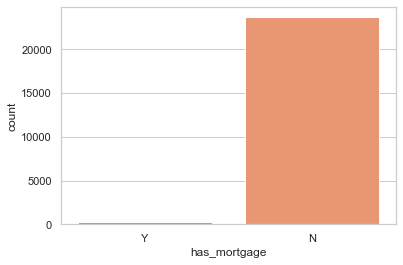

In [9]:
fig = plt.figure()
mortgage = sns.countplot(x='has_mortgage',data=retail_data)     
Counter(retail_data.has_mortgage.values)

- Dataset has skewed distribution.

### Observing the variables effect on the target variable
  
Average age of people when they got mortgage:

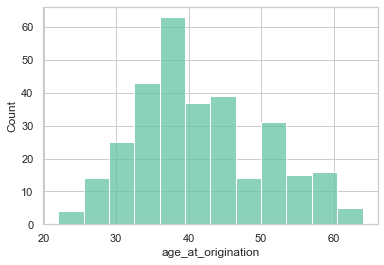

In [10]:
customers_with_mortgage = retail_data[retail_data.has_mortgage == 'Y']

age = sns.histplot(x='age_at_origination',data=customers_with_mortgage)

- Age of people when they accepted mortgage is in range 38-40 years.

Employment 

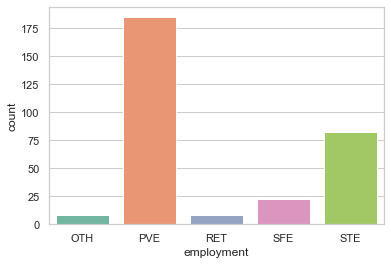

In [11]:
employment_plot = sns.countplot(x='employment',data=customers_with_mortgage)

- The majority of mortgage users are employed(PVE).

Gender

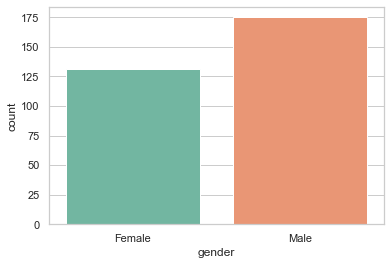

In [12]:
gender_plot = sns.countplot(x='gender',data=customers_with_mortgage)

- Gender may not have any significant impact when it comes to mortgage status.

Marital status

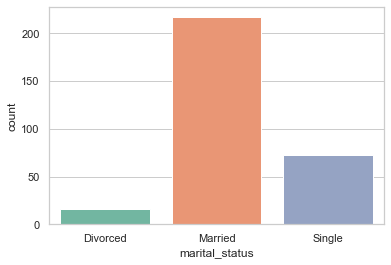

In [13]:
gender_plot = sns.countplot(x='marital_status',data=customers_with_mortgage)

- Married people are more likely to have mortgage.

Education

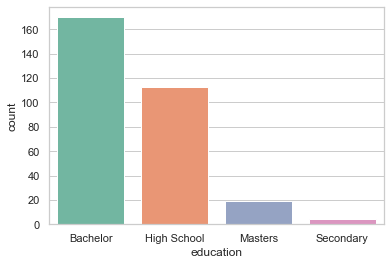

In [14]:
education_plot = sns.countplot(x='education',data=customers_with_mortgage)

- The majority of mortgage users have Bachelor degreee.

### Plotting the target vs distribution of numerical variables: customer income, current_balance_eur

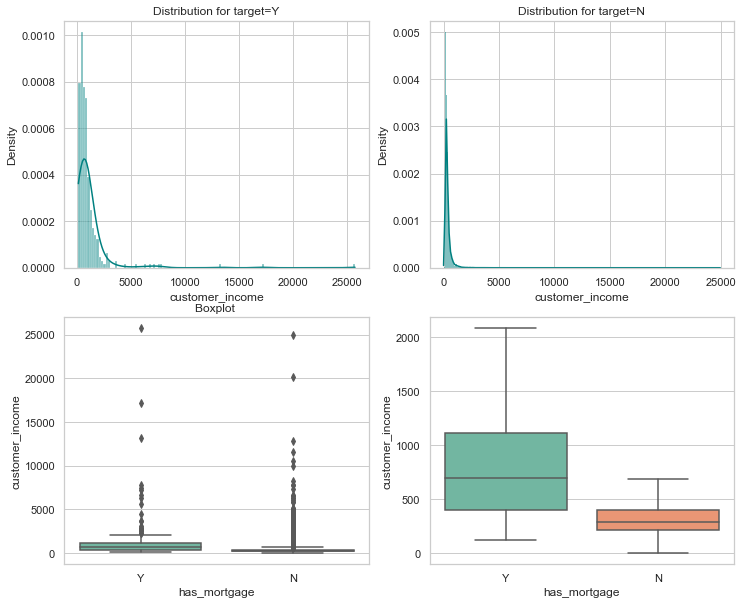

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

target_uniq = retail_data.has_mortgage.unique()
ax[0, 0].set_title("Distribution for target=" + str(target_uniq[0]))
#ax[0, 0].set_xlim(-5,20)
sns.histplot(data=retail_data[retail_data.has_mortgage == target_uniq[0]],x='customer_income',kde=True,ax=ax[0, 0],color="teal",stat="density",)

target_uniq = retail_data.has_mortgage.unique()
ax[0, 1].set_title("Distribution for target=" + str(target_uniq[1]))
#ax[0, 1].set_xlim(-5,20)
sns.histplot(data=retail_data[retail_data.has_mortgage == target_uniq[1]],x='customer_income',kde=True,ax=ax[0, 1],color="teal",stat="density",)

ax[1, 0].set_title("Boxplot ")
sns.boxplot(data=retail_data, x='has_mortgage', y='customer_income', ax=ax[1, 0])
plot = sns.boxplot(data=retail_data, x='has_mortgage', y='customer_income', ax=ax[1, 1],showfliers=False)

Confusion matrix:

,has_mortgage,age_at_origination,age,years_with_bank,marital_status,education,employment,gender,customer_income,current_address_date,current_job_date,current_with_bank_date,current_balance_eur,years_on_current_address,years_on_current_job
0,Y,50.0,52,13,Married,High School,PVE,Male,909.501308,1979-04-18,2010-01-01,2004-03-16,7648.350692,37,6
1,Y,48.0,49,11,Married,High School,SFE,Male,288.461539,1999-12-16,2004-01-20,2005-11-07,30189.904920,17,12
2,Y,53.0,55,14,Married,Bachelor,STE,Male,1280.528692,2005-06-28,1990-09-01,2003-06-25,50553.174540,11,26
3,Y,64.0,66,10,Married,Bachelor,OTH,Female,620.959769,2000-12-22,1677-09-22,2006-12-21,15907.283380,16,0
4,Y,46.0,47,9,Single,Masters,PVE,Female,2239.853846,2009-08-01,2013-12-24,2007-08-07,27916.192620,7,3


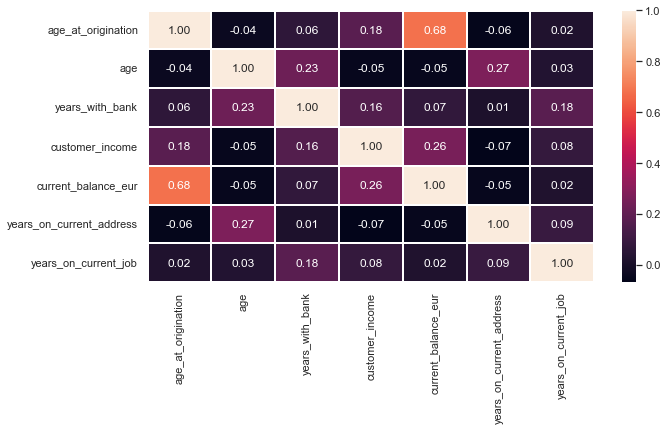

In [16]:
fig = plt.figure(figsize=(10, 5))
corr = retail_data.corr()
hm = sns.heatmap(round(corr,2), annot=True,fmt='.2f',linewidths=.05)

retail_data.head()

<Figure size 1080x1080 with 0 Axes>

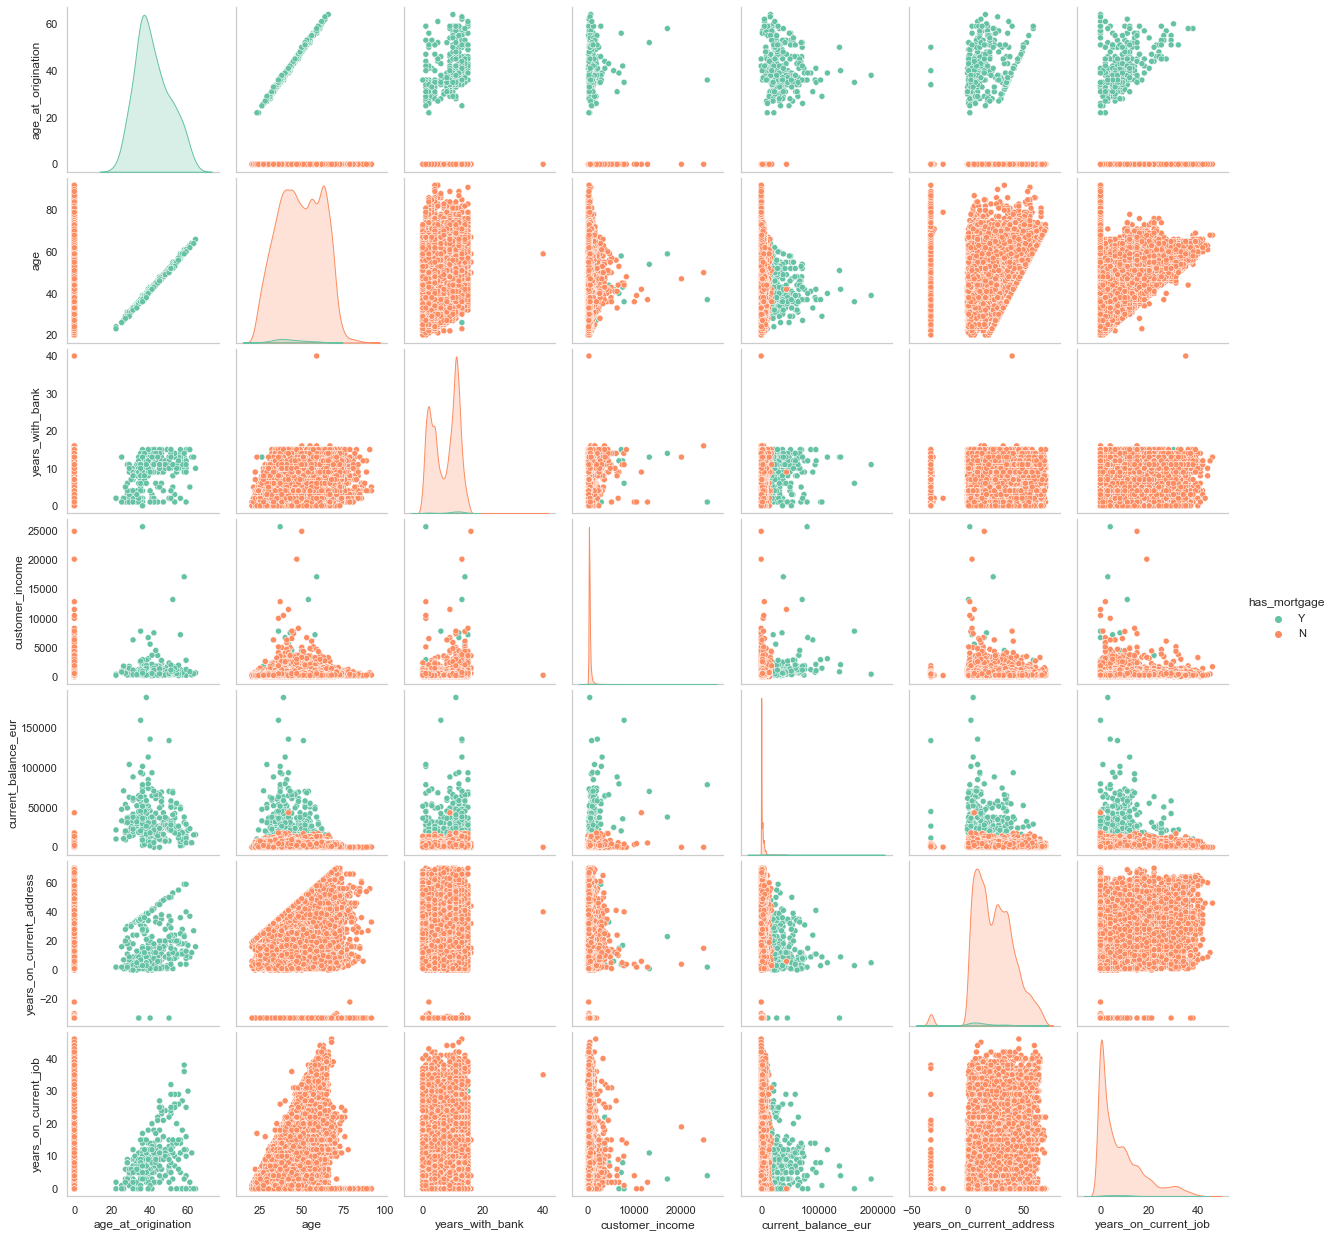

In [17]:
fig = plt.figure(figsize=(15,15))
sns.set_style({'axes.grid' : False})
plot = sns.pairplot(retail_data, hue = "has_mortgage")
plt.show()

- The green spots represent the customers with mortgage, the orange ones represent without the mortgage.
 

Other things can further be explored, such as correlations between some variables, exploring/transforming variables related to time format, etc

# Model building

The general orientation is maintained rather than redefining the meaning of positive and negative. Binary classification model with positives/negatives is used.
Dataset is imbalanced, with low number of positives (~1%) and high number of negatives. Some techniques to balance dataset are applied later


  Scaling numerical features

In [18]:
numeric_feature_names = ['age', 'years_with_bank','customer_income', 'current_balance_eur']

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(retail_data[numeric_feature_names])
retail_data[numeric_feature_names] = ss.transform(retail_data[numeric_feature_names])

One hot encoding for categorical features

In [19]:
retail_data['has_mortgage'] = retail_data['has_mortgage'].map({'Y': 1, 'N': 0})

df_model = pd.get_dummies(retail_data, columns=['marital_status','education','gender','employment'], drop_first= True)
    
X = df_model.drop(['age_at_origination','has_mortgage','current_address_date','current_job_date','current_with_bank_date'],axis=1)
y = retail_data['has_mortgage']


Some classification models are considered, such as:
- Logistic Regression
- Decision trees
- Random forests
- SVM
- Neural networks

Logistic regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lg = LogisticRegression(solver="newton-cg", random_state=1)
model = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
       
print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred))) 

accuracy score: 0.9972

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7098
           1       0.96      0.82      0.89        97

    accuracy                           1.00      7195
   macro avg       0.98      0.91      0.94      7195
weighted avg       1.00      1.00      1.00      7195


Confusion Matrix: 
 [[7095    3]
 [  17   80]]



- Since dataset is unbalanced, some other tecnhiques such as oversampling are added. Further tuning needeed.  
- The estimate is changed from accuracy to other measures. 

Model evaluation:    
Predicting a customer will 'accept' a mortgage but in reality the customer would not.  
Predicting a customer will not accept but in reality the customer would have accepted a mortgaga -loss of opportunity. Reducing FN, recall.

Logistic regression with oversampling

In [21]:
over = RandomOverSampler(sampling_strategy=1)
X_smote, y_smote = over.fit_resample(X_train, y_train)
model = LogisticRegression().fit(X_smote, y_smote)
y_pred = model.predict(X_test)

print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))

accuracy score: 0.9754

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      7098
           1       0.35      0.95      0.51        97

    accuracy                           0.98      7195
   macro avg       0.67      0.96      0.75      7195
weighted avg       0.99      0.98      0.98      7195




Random forest with weights

accuracy score: 0.9967

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7098
           1       0.95      0.79      0.87        97

    accuracy                           1.00      7195
   macro avg       0.97      0.90      0.93      7195
weighted avg       1.00      1.00      1.00      7195


Confusion Matrix: 
 [[7094    4]
 [  20   77]]



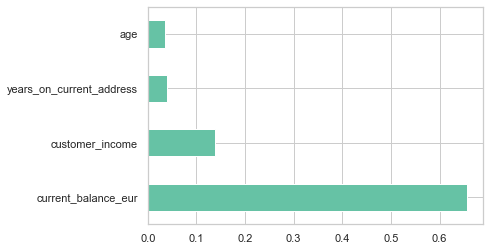

In [22]:
rf = RandomForestClassifier(n_estimators=10, class_weight='balanced')
model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
       
print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred))) 

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plot = feat_importances.nlargest(4).plot(kind='barh',grid='False')

XGBoost

accuracy score: 0.9971

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7098
           1       0.90      0.89      0.89        97

    accuracy                           1.00      7195
   macro avg       0.95      0.94      0.94      7195
weighted avg       1.00      1.00      1.00      7195


Confusion Matrix: 
 [[7088   10]
 [  11   86]]



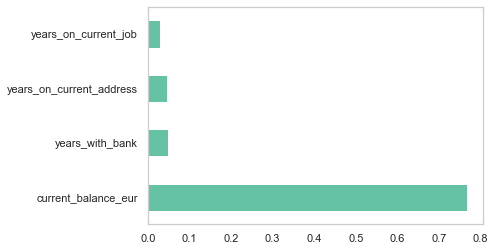

In [23]:
xgb = XGBClassifier(scale_pos_weight=99,use_label_encoder=False, eval_metric='logloss')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
model = xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
       
print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred))) 

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(4).plot(kind='barh')

filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

y_pred_prob = xgb.predict_proba(X_test) # output as probabilities.
# The model should be used on potential_customers set. Plot auc and other. Additional analysis. 
# Separate function for accuracy, classification, confusion matrix.
# Visual of confusion matrix. Further investigate models.